In [1]:
# Essential library imports
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
#from google.colab import drive
import cv2
import tensorflow as tf



In [2]:
# # mount drive

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# suppress warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
# gpu check

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
print(f"Using GPU: {tf.config.list_physical_devices('GPU')}")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [6]:
# # unzip file

# !unzip "/content/drive/MyDrive/Skin_Dataset.zip" -d "/content/drive/MyDrive/Skin_Dataset"

In [7]:
# Data Paths
TRAIN_DIR = '/kaggle/input/skin-disease-dataset/Skin_Dataset/train'
TEST_DIR = '/kaggle/input/skin-disease-dataset/Skin_Dataset/test'

# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_data_gen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_data_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8419 images belonging to 9 classes.
Found 920 images belonging to 9 classes.


In [8]:
# Class names and count
class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)
print('Classes:', class_names)


Classes: ['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis', 'Bacterial Skin Infection', 'Drug Eruptions', 'Eczema', 'Herpes Simplex', 'acne', 'keratosis Pilaris', 'rosacea']


In [9]:
# Load images and labels
labels = []
images = []

for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    print(f"Loading images from {class_name}")
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Check if the file is an image file before attempting to load it
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(img_path)

            # Check if the image was loaded successfully
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                label = np.zeros(num_classes)
                label[class_names.index(class_name)] = 1
                labels.append(label)
            else:
                print(f"Warning: Could not load image: {img_path}")
        else:
            print(f"Skipping non-image file: {img_path}")

images = np.array(images)
labels = np.array(labels)
print(f"Loaded {len(images)} images of shape {images.shape}")

Loading images from Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
Loading images from Atopic Dermatitis
Loading images from Bacterial Skin Infection
Loading images from Drug Eruptions
Loading images from Eczema
Loading images from Herpes Simplex
Loading images from acne
Skipping non-image file: /kaggle/input/skin-disease-dataset/Skin_Dataset/train/acne/desktop.ini
Loading images from keratosis Pilaris
Loading images from rosacea
Skipping non-image file: /kaggle/input/skin-disease-dataset/Skin_Dataset/train/rosacea/desktop.ini
Loaded 8419 images of shape (8419, 128, 128, 3)


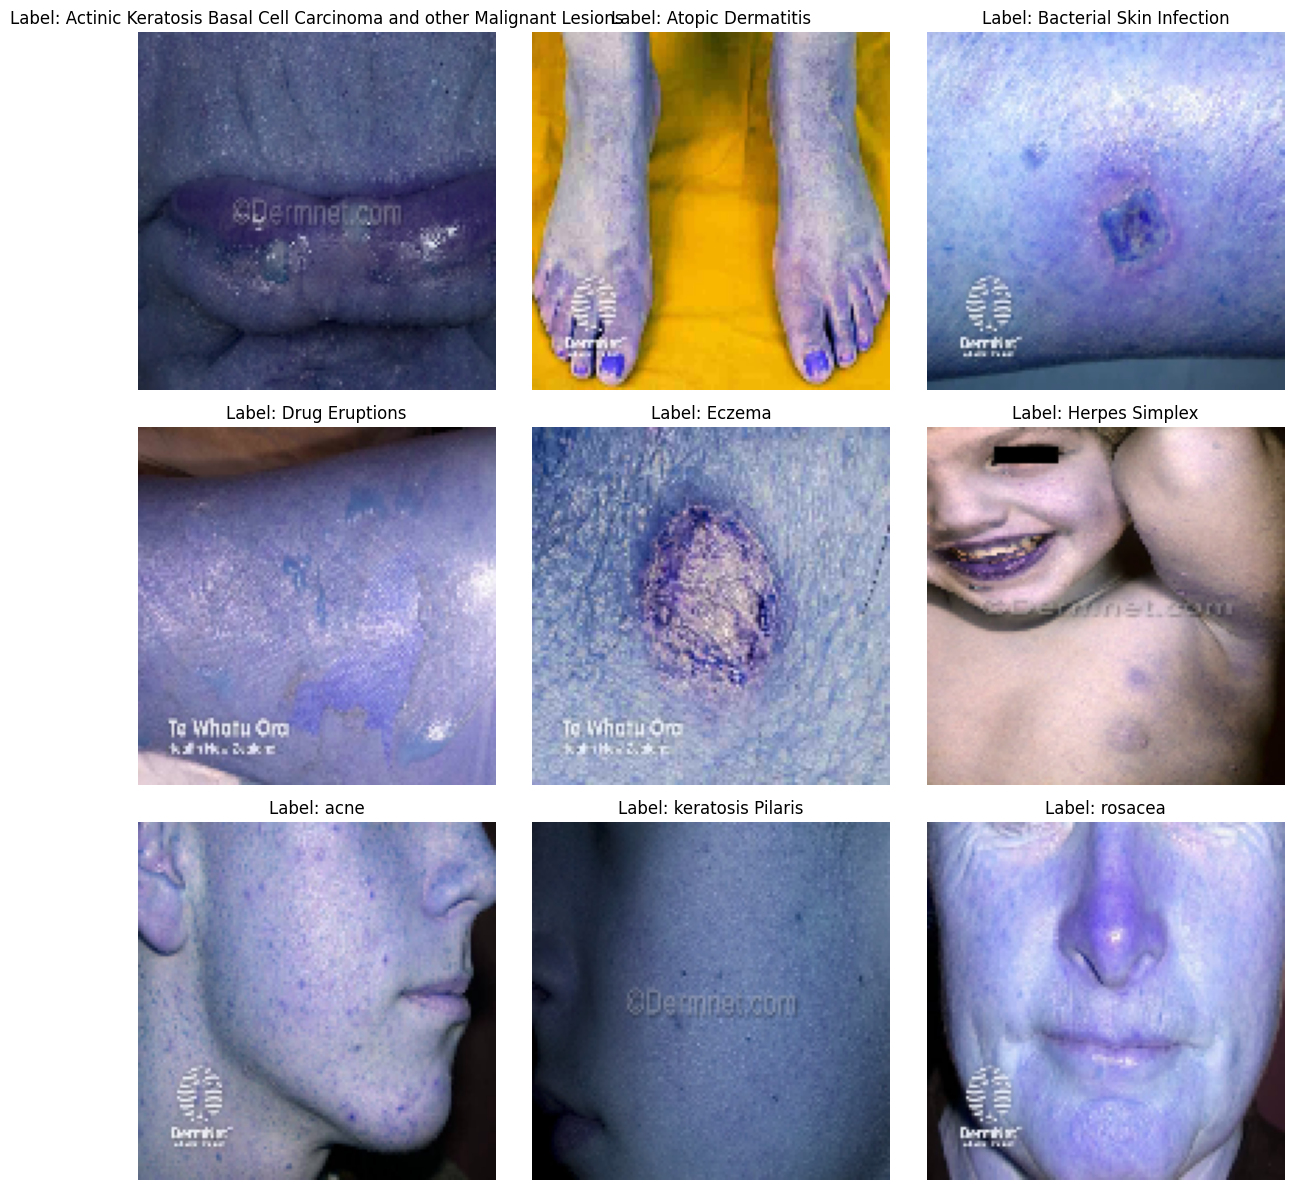

In [10]:
# Display 9 larger images with diversity
def display_sample_images(images, labels, class_names, num_samples=9):
    plt.figure(figsize=(12, 12))  # Adjust the figure size for larger visuals
    selected_indices = []

    # Diversity by picking images from different classes
    for class_idx, class_name in enumerate(class_names):
        class_indices = [i for i, label in enumerate(labels) if np.argmax(label) == class_idx]
        if len(class_indices) > 0:
            selected_indices.append(np.random.choice(class_indices))

    # Fill the remaining slots with random images if less than 9 classes
    while len(selected_indices) < num_samples:
        selected_indices.append(np.random.choice(len(images)))

    selected_indices = selected_indices[:num_samples]

    for i, idx in enumerate(selected_indices):
        plt.subplot(3, 3, i + 1)  # 3x3 grid
        plt.imshow(images[idx])
        plt.title(f"Label: {class_names[np.argmax(labels[idx])]}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display exactly 9 images
display_sample_images(images, labels, class_names, num_samples=9)


In [11]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.15, random_state=42
)
print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")


Training data: (7156, 128, 128, 3), Validation data: (1263, 128, 128, 3)


In [12]:
# Model building
model = Sequential([
    Rescaling(1.0 / 255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # Conv Block 1
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Conv Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Conv Block 3
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,956,937 (68.50 MB)

 Trainable params: 17,956,937 (68.50 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model checkpointing
checkpoint_callback = ModelCheckpoint(
    filepath='cnn_model_checkpoint.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,  # Save the entire model (architecture + weights)
    verbose=1
)

In [14]:
# Model training
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback]
)


Epoch 1/20


I0000 00:00:1733715654.500027      85 service.cc:145] XLA service 0x7b7ec4011bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733715654.500083      85 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733715654.500089      85 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/224 ━━━━━━━━━━━━━━━━━━━━ 1:11:57 19s/step - accuracy: 0.0938 - loss: 2.1950

I0000 00:00:1733715671.598967      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.1227 - loss: 2.2407
Epoch 1: val_accuracy improved from -inf to 0.14252, saving model to cnn_model_checkpoint.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 54s 154ms/step - accuracy: 0.1228 - loss: 2.2405 - val_accuracy: 0.1425 - val_loss: 2.1760
Epoch 2/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1370 - loss: 2.1702
Epoch 2: val_accuracy did not improve from 0.14252
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.1370 - loss: 2.1702 - val_accuracy: 0.1180 - val_loss: 2.1779
Epoch 3/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1351 - loss: 2.1784
Epoch 3: val_accuracy did not improve from 0.14252
224/224 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.1351 - loss: 2.1784 - val_accuracy: 0.1180 - val_loss: 2.1757
Epoch 4/20
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1228 - loss: 2.1787
Epoch 4: val_accuracy did not improve from 0.14252
224/224 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 

### Another method

In [15]:
Actinic_Keratosis_Basal_Cell_Carcinoma = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions"
Atopic_Dermatitis = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/Atopic Dermatitis"
Bacterial_Skin_Infection = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/Bacterial Skin Infection"
Drug_Eruptions = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/Drug Eruptions"
Eczema = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/Eczema"
Herpes_Simplex = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/Herpes Simplex"
Acne = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/acne"
Keratosis_Pilaris = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/keratosis Pilaris"
Rosacea = "/kaggle/input/skin-disease-dataset/Skin_Dataset/train/rosacea"

In [16]:
cv2.imread(r"/kaggle/input/skin-disease-dataset/Skin_Dataset/train/Atopic Dermatitis/020612122803-38 - Copy (2).jpg")

array([[[119,  82,  86],
        [112,  75,  79],
        [102,  65,  69],
        ...,
        [188, 147, 144],
        [185, 144, 141],
        [177, 136, 133]],

       [[115,  78,  82],
        [110,  73,  77],
        [101,  64,  68],
        ...,
        [191, 150, 147],
        [189, 148, 145],
        [182, 141, 138]],

       [[109,  72,  76],
        [107,  70,  74],
        [100,  63,  67],
        ...,
        [188, 147, 144],
        [189, 148, 145],
        [183, 142, 139]],

       ...,

       [[107, 130, 156],
        [102, 125, 151],
        [ 98, 121, 147],
        ...,
        [108,  71,  75],
        [111,  74,  78],
        [114,  77,  81]],

       [[104, 127, 153],
        [100, 123, 149],
        [ 96, 119, 145],
        ...,
        [112,  75,  79],
        [113,  76,  80],
        [113,  76,  80]],

       [[100, 123, 149],
        [ 97, 120, 146],
        [ 93, 116, 142],
        ...,
        [115,  78,  82],
        [113,  76,  80],
        [112,  75,  79]]

In [17]:
X = []
y = []


for filename in os.listdir(Actinic_Keratosis_Basal_Cell_Carcinoma):
    try:
        img = cv2.imread(f"{Actinic_Keratosis_Basal_Cell_Carcinoma}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(0)
    except:
        pass #(this will skip the faulty image)

In [18]:
len(X)

1137

In [19]:
len(y)

1137

In [20]:

for filename in os.listdir(Atopic_Dermatitis):

    try:
        img = cv2.imread(f"{Atopic_Dermatitis}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(1)
    except:
        pass #(this will skip the faulty image)

In [21]:

for filename in os.listdir(Bacterial_Skin_Infection):

    try:
        img = cv2.imread(f"{Bacterial_Skin_Infection}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(2)
    except:
        pass #(this will skip the faulty image)

In [22]:

for filename in os.listdir(Drug_Eruptions):

    try:
        img = cv2.imread(f"{Drug_Eruptions}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(3)
    except:
        pass #(this will skip the faulty image)

In [23]:

for filename in os.listdir(Eczema):

    try:
        img = cv2.imread(f"{Eczema}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(4)
    except:
        pass #(this will skip the faulty image)

In [24]:

for filename in os.listdir(Herpes_Simplex):

    try:
        img = cv2.imread(f"{Herpes_Simplex}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(5)
    except:
        pass #(this will skip the faulty image)

In [25]:

for filename in os.listdir(Acne):

    try:
        img = cv2.imread(f"{Acne}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(6)
    except:
        pass #(this will skip the faulty image)

In [26]:

for filename in os.listdir(Keratosis_Pilaris):

    try:
        img = cv2.imread(f"{Keratosis_Pilaris}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(7)
    except:
        pass #(this will skip the faulty image)

In [27]:

for filename in os.listdir(Rosacea):

    try:
        img = cv2.imread(f"{Rosacea}/{filename}")
        img = cv2.resize(img, (60,60))
        img = img/255

        X.append(img)
        y.append(8)
    except:
        pass #(this will skip the faulty image)

In [28]:
len(X)

8419

In [29]:
len(y)

8419

In [30]:
X_arr = np.array(X)
y_arr = np.array(y)

In [31]:
X_arr.shape

(8419, 60, 60, 3)

In [32]:
y_arr.shape

(8419,)

In [33]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_arr, y_arr, test_size=0.15, random_state=42
)
print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")


Training data: (7156, 60, 60, 3), Validation data: (1263, 60, 60, 3)


In [34]:
model2 = Sequential(

[Conv2D(filters = 64, kernel_size = (3,3), strides = 1, activation = 'relu', input_shape = (60,60,3)),
 MaxPooling2D(),
 Conv2D(filters = 128,kernel_size = (3,3), strides = 1, activation = 'relu'),
 MaxPooling2D(),
 Flatten(),
 Dense(units =32, activation = 'relu'),
 Dense(units = 16, activation = 'relu'),
 Dense(units = 1, activation = 'sigmoid')
]

)

In [35]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 58, 58, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │       692,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 768,449 (2.93 MB)

 Trainable params: 768,449 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D,Conv2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import save_model

In [37]:
# model.compile

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
es = EarlyStopping(min_delta = 0.002, patience = 7, verbose = 1,
                  restore_best_weights = True)

In [39]:
history2 = model2.fit(X_train, y_train, epochs = 30, batch_size = 3000, verbose = 1,
         validation_data=(X_val, y_val), callbacks =[es])

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - accuracy: 0.1330 - loss: nan - val_accuracy: 0.1425 - val_loss: nan
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.1334 - loss: nan - val_accuracy: 0.1425 - val_loss: nan
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.1338 - loss: nan - val_accuracy: 0.1425 - val_loss: nan
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.1333 - loss: nan - val_accuracy: 0.1425 - val_loss: nan
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.1318 - loss: nan - val_accuracy: 0.1425 - val_loss: nan
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.1339 - loss: nan - val_accuracy: 0.1425 - val_loss: nan
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.1301 - loss: nan - val_accuracy: 0.1425 - val_loss: nan
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 1.


### MobileNet V2


In [40]:
# Data Paths
TRAIN_DIR = '/kaggle/input/skin-disease-dataset/Skin_Dataset/train'
TEST_DIR = '/kaggle/input/skin-disease-dataset/Skin_Dataset/test'

# Parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_data_gen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_data_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_data_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8419 images belonging to 9 classes.
Found 920 images belonging to 9 classes.


In [41]:
# Class names and count
class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)
print('Classes:', class_names)


Classes: ['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis', 'Bacterial Skin Infection', 'Drug Eruptions', 'Eczema', 'Herpes Simplex', 'acne', 'keratosis Pilaris', 'rosacea']


In [42]:
# Load images and labels
labels = []
images = []

for class_name in class_names:
    class_path = os.path.join(TRAIN_DIR, class_name)
    print(f"Loading images from {class_name}")
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        # Check if the file is an image file before attempting to load it
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(img_path)

            # Check if the image was loaded successfully
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                label = np.zeros(num_classes)
                label[class_names.index(class_name)] = 1
                labels.append(label)
            else:
                print(f"Warning: Could not load image: {img_path}")
        else:
            print(f"Skipping non-image file: {img_path}")

images = np.array(images)
labels = np.array(labels)
print(f"Loaded {len(images)} images of shape {images.shape}")

Loading images from Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
Loading images from Atopic Dermatitis
Loading images from Bacterial Skin Infection
Loading images from Drug Eruptions
Loading images from Eczema
Loading images from Herpes Simplex
Loading images from acne
Skipping non-image file: /kaggle/input/skin-disease-dataset/Skin_Dataset/train/acne/desktop.ini
Loading images from keratosis Pilaris
Loading images from rosacea
Skipping non-image file: /kaggle/input/skin-disease-dataset/Skin_Dataset/train/rosacea/desktop.ini
Loaded 8419 images of shape (8419, 160, 160, 3)


In [43]:
from tensorflow.keras.applications import mobilenet_v2

In [44]:
m = mobilenet_v2.MobileNetV2(input_shape = (160,160,3), include_top = False, classes = 9, classifier_activation = 'sigmoid',
                            )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
# Model checkpointing
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/mobilenet_model_checkpoint.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,  # Save the entire model (architecture + weights)
    verbose=1
)

In [46]:
model = Sequential()
model.add(m)
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(9, activation = 'softmax'))

In [47]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [48]:
X_train, X_val, y_train, y_val = train_test_split(images, labels,
                                                   test_size = 0.30,
                                                   random_state = 9)

In [49]:
historymobile = model.fit(X_train, y_train, epochs = 50, batch_size = BATCH_SIZE, verbose = 1, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5192 - loss: 1.5536

I0000 00:00:1733716255.173868      83 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion_1', 136 bytes spill stores, 144 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.15677, saving model to /kaggle/working/mobilenet_model_checkpoint.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 74s 192ms/step - accuracy: 0.5196 - loss: 1.5520 - val_accuracy: 0.1568 - val_loss: 3.7906
Epoch 2/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7056 - loss: 0.9371
Epoch 2: val_accuracy improved from 0.15677 to 0.26841, saving model to /kaggle/working/mobilenet_model_checkpoint.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.7060 - loss: 0.9359 - val_accuracy: 0.2684 - val_loss: 3.2648
Epoch 3/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7938 - loss: 0.6857
Epoch 3: val_accuracy did not improve from 0.26841
185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7940 - loss: 0.6851 - val_accuracy: 0.2260 - val_loss: 4.1936
Epoch 4/50
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8366 - loss: 0.5807
Epoch 4: val_accuracy did not improve from 0.26841
185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/s

MobileNetV2 Model - Validation Loss: 1.1823, Validation Accuracy: 0.8017


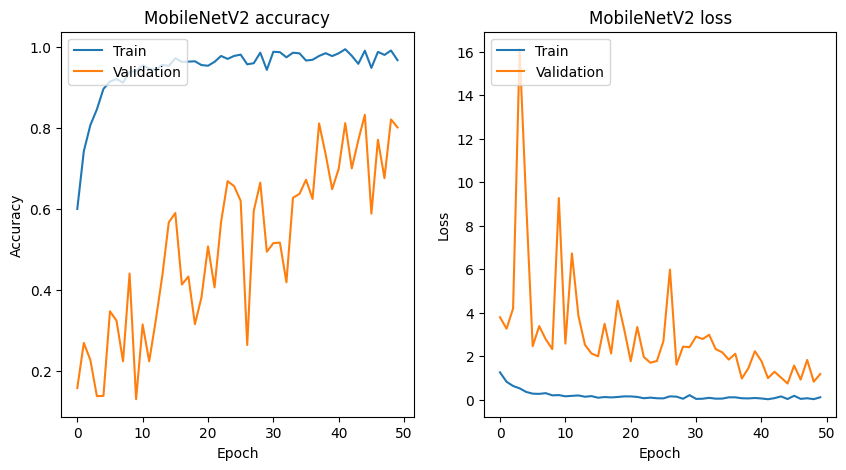

In [50]:
# Evaluate the MobileNetV2 model
loss_mobile, accuracy_mobile = model.evaluate(X_val, y_val, verbose=0)
print(f"MobileNetV2 Model - Validation Loss: {loss_mobile:.4f}, Validation Accuracy: {accuracy_mobile:.4f}")

# Plot training & validation accuracy values for MobileNetV2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(historymobile.history['accuracy'])
plt.plot(historymobile.history['val_accuracy'])
plt.title('MobileNetV2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values for MobileNetV2
plt.subplot(1, 2, 2)
plt.plot(historymobile.history['loss'])
plt.plot(historymobile.history['val_loss'])
plt.title('MobileNetV2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
# Save the final trained model
model.save('/kaggle/working/mobilenet_final_model.h5')


In [52]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/kaggle/working/mobilenet_model_checkpoint.keras')


79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step
Confusion Matrix:
[[312   5   9   3   0   1   2   0   1]
 [  3 249   7  13  31   0  13   0   0]
 [  7  12 259  28  17   0   1   0   2]
 [  5   0   6 330   0   4   0   0   0]
 [  2   1   6   0 257   0   1   0   1]
 [  7   4   0   0   1 277   0   0   0]
 [ 15   6  36   4  23   8  42   0   1]
 [  0  19  47  14  19  17  47 109   0]
 [  8   0  18   6  12   5   3   0 190]]


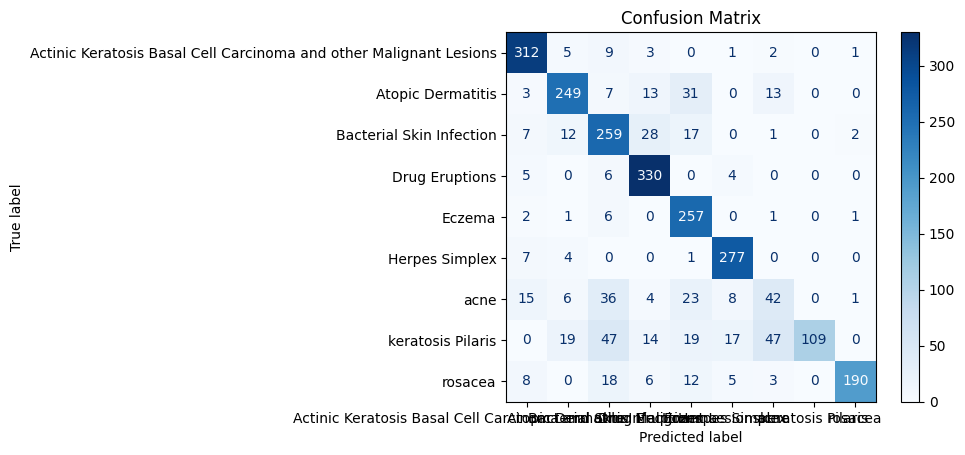

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict labels for the validation/test set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Convert true labels to class indices if one-hot encoded
y_true = np.argmax(y_val, axis=1)

# Step 3: Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Step 4: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [54]:
import numpy as np

# Get predicted class labels
y_pred = np.argmax(model.predict(X_val), axis=1)

# Get true class labels
y_true = np.argmax(y_val, axis=1)


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [55]:
print(list(y_pred))

[1, 2, 4, 0, 1, 7, 0, 2, 3, 3, 4, 2, 3, 4, 1, 6, 2, 7, 0, 6, 2, 3, 1, 7, 5, 7, 3, 5, 5, 3, 2, 1, 3, 8, 5, 2, 2, 2, 6, 5, 3, 7, 5, 1, 8, 3, 2, 8, 3, 3, 3, 7, 6, 3, 7, 5, 2, 8, 8, 3, 3, 1, 4, 3, 1, 6, 4, 5, 2, 3, 0, 0, 4, 1, 3, 1, 2, 4, 1, 3, 3, 4, 3, 6, 1, 1, 7, 0, 1, 0, 2, 4, 3, 3, 0, 3, 2, 5, 3, 8, 8, 2, 0, 5, 0, 5, 1, 0, 7, 2, 0, 5, 0, 6, 0, 3, 4, 4, 0, 0, 4, 2, 8, 1, 5, 2, 3, 0, 0, 3, 0, 7, 5, 1, 8, 2, 3, 0, 4, 5, 0, 2, 8, 4, 1, 0, 4, 3, 3, 5, 5, 0, 4, 3, 8, 1, 4, 8, 2, 1, 6, 1, 8, 4, 2, 3, 2, 1, 4, 4, 8, 1, 4, 4, 4, 4, 7, 0, 0, 5, 1, 5, 5, 4, 5, 0, 8, 4, 5, 3, 2, 1, 0, 4, 0, 4, 5, 2, 0, 3, 3, 0, 3, 7, 3, 6, 0, 8, 0, 1, 3, 8, 4, 4, 5, 1, 5, 5, 0, 0, 2, 3, 8, 5, 5, 4, 7, 5, 4, 2, 7, 0, 4, 0, 4, 1, 2, 3, 4, 3, 2, 4, 0, 6, 3, 4, 6, 2, 3, 5, 3, 6, 1, 2, 6, 0, 2, 1, 2, 3, 0, 0, 2, 3, 1, 3, 2, 2, 2, 8, 2, 5, 2, 2, 2, 2, 4, 3, 0, 2, 1, 0, 5, 3, 6, 4, 3, 5, 4, 6, 5, 3, 0, 2, 4, 2, 2, 8, 2, 2, 1, 2, 4, 5, 0, 3, 4, 4, 8, 1, 3, 4, 3, 2, 3, 3, 0, 5, 6, 3, 6, 5, 2, 0, 8, 2, 1, 5, 8, 6, 6, 4, 4, 

In [56]:
print(list(y_true))

[1, 8, 4, 0, 1, 7, 0, 7, 3, 3, 4, 2, 3, 4, 1, 7, 2, 7, 0, 7, 1, 3, 1, 7, 5, 7, 2, 5, 5, 3, 2, 1, 3, 8, 5, 2, 6, 2, 6, 5, 3, 7, 5, 1, 8, 3, 2, 8, 7, 3, 3, 7, 7, 3, 7, 5, 7, 8, 8, 3, 0, 1, 4, 3, 1, 7, 4, 5, 6, 3, 0, 0, 4, 1, 3, 1, 2, 4, 1, 3, 3, 6, 3, 6, 0, 1, 7, 0, 1, 0, 2, 4, 2, 3, 0, 6, 1, 5, 3, 8, 8, 4, 2, 7, 0, 5, 1, 0, 7, 3, 0, 5, 0, 6, 0, 3, 4, 6, 0, 0, 4, 6, 8, 1, 5, 7, 3, 0, 0, 3, 0, 7, 5, 1, 8, 2, 3, 0, 4, 5, 0, 6, 8, 4, 1, 0, 4, 3, 3, 5, 5, 0, 4, 3, 8, 1, 4, 8, 2, 1, 7, 1, 8, 4, 2, 3, 8, 1, 4, 4, 8, 1, 4, 6, 4, 4, 7, 0, 0, 5, 1, 5, 5, 4, 5, 0, 8, 4, 5, 3, 2, 1, 0, 4, 0, 4, 5, 2, 0, 3, 3, 4, 3, 7, 3, 6, 0, 8, 0, 1, 3, 8, 4, 4, 5, 1, 5, 5, 0, 0, 0, 3, 8, 5, 5, 2, 7, 5, 4, 6, 7, 0, 2, 0, 4, 1, 7, 8, 4, 3, 2, 4, 0, 7, 3, 4, 7, 2, 3, 5, 3, 1, 1, 2, 6, 0, 2, 1, 2, 3, 0, 0, 2, 3, 1, 3, 7, 2, 2, 8, 2, 5, 2, 2, 2, 2, 4, 1, 2, 2, 1, 0, 3, 3, 6, 4, 3, 5, 8, 1, 5, 3, 0, 2, 4, 2, 2, 8, 2, 2, 7, 2, 4, 7, 0, 2, 4, 4, 8, 1, 3, 4, 3, 0, 1, 3, 0, 5, 0, 3, 6, 5, 2, 0, 8, 2, 2, 5, 8, 7, 1, 4, 4, 

In [57]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.94      0.90       333
           1       0.84      0.79      0.81       316
           2       0.67      0.79      0.73       326
           3       0.83      0.96      0.89       345
           4       0.71      0.96      0.82       268
           5       0.89      0.96      0.92       289
           6       0.39      0.31      0.34       135
           7       1.00      0.40      0.57       272
           8       0.97      0.79      0.87       242

    accuracy                           0.80      2526
   macro avg       0.80      0.77      0.76      2526
weighted avg       0.82      0.80      0.79      2526

